**Desciption Field** 

Shared Fields
* `PULocationID` - TLC Taxi Zone in which the taximeter was engaged.
* `DOLocationID` - TLC Taxi Zone in which the taximeter was disengaged.
* `tpep_pickup_datetime/lpep_pickup_datetime/Pickup_datetime` - The date and time when the meter was engaged.
* `tpep_dropoff_datetime/lpep_dropoff_datetime/DropOff_datetime` - The date and time when the meter was disengaged.

Green & Yellow Taxi
* `vendor_id` - A code indicating the LPEP provider that provided the record.

    ( 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc. )
* `passenger_count` - the number of passengers in the vehicle (driver entered value)
* `Trip_distance` - The elapsed trip distance in ***miles*** reported by the taximeter.
* `RateCodeID` - The final rate code in effect at the end of the trip.

    ( 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride )
* `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server.
(Y=store and forward; N=not a store and forward trip).
* `Payment_type` - A numeric code signifying how the passenger paid for the trip.

    ( 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided trip )
* `Fare_amount` - The time-and-distance fare
calculated by the meter.
* `Extra` - Miscellaneous extras and surcharges.  Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges.
* `MTA_tax` - \$0.50 MTA tax that is automatically triggered based on the metered rate in use.
* `Improvement_surcharge` - \$0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015.

    [ phụ phí cải thiện cho xe đc đáng giá tốt ]
* `Tip_amount` - Tip amount-This field is automatically populated for credit card tips. Cash tips are not included.
* `Tolls_amount` - Total amount of all tolls paid in trip.
* `Total_amount` - The total amount charged to passengers. Does not include cash tips.

Green Taxi
* `Trip_type` - A code indicating whether the tripwas a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver.

    ( 1= Street-hail 2= Dispatch )
* `ehail-fee` is not explained in **Trip Records User Guide** so we remove that

Yellow Taxi
* `airport_fee` - \$1.25 for pick up only at LaGuardiaand John F. Kennedy Airports

FHVH Taxi
* `Dispatching_base_num`- The TLC Base License Number of the base that dispatched the trip
* `SR_Flag` - SR_FlagIndicates if the trip was a part of a shared ride chain offered by a High Volume FHV company (e.g.Uber Pool, Lyft Line). Forshared trips, the value is 1. For non-shared rides, this field is null.

### Library

In [107]:
import glob
from geopy.distance import great_circle
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pandas.api.types import CategoricalDtype
import numpy as np
from scipy import stats
import pickle
import re

import io
import base64
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import animation
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.pyplot import Arrow

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### prepare

In [2]:
filenames = glob.glob("*.parquet")
filenames

['fhv_tripdata_2023-06.parquet',
 'yellow_tripdata_2023-06.parquet',
 'green_tripdata_2023-06.parquet']

In [3]:
fhvhv_tripdata = pd.read_parquet(filenames[0])
yellow_tripdata = pd.read_parquet(filenames[1])
green_tripdata  = pd.read_parquet(filenames[2])
fhvhv_tripdata.size, green_tripdata.size, yellow_tripdata.size

(8536115, 1311000, 62837446)

In [5]:
nyc_weather_2021 = pd.read_csv('/home/hungnq/hungnq_2/taxi_EDA/weather_june_2023_NYC.csv')
nyc_weather_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              30 non-null     object 
 1   datetime          30 non-null     object 
 2   tempmax           30 non-null     float64
 3   tempmin           30 non-null     float64
 4   temp              30 non-null     float64
 5   feelslikemax      30 non-null     float64
 6   feelslikemin      30 non-null     float64
 7   feelslike         30 non-null     float64
 8   dew               30 non-null     float64
 9   humidity          30 non-null     float64
 10  precip            30 non-null     float64
 11  precipprob        30 non-null     int64  
 12  precipcover       30 non-null     float64
 13  preciptype        21 non-null     object 
 14  snow              30 non-null     int64  
 15  snowdepth         30 non-null     int64  
 16  windgust          30 non-null     float64
 17 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int64   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int64   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 14.5+ KB
['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']


<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

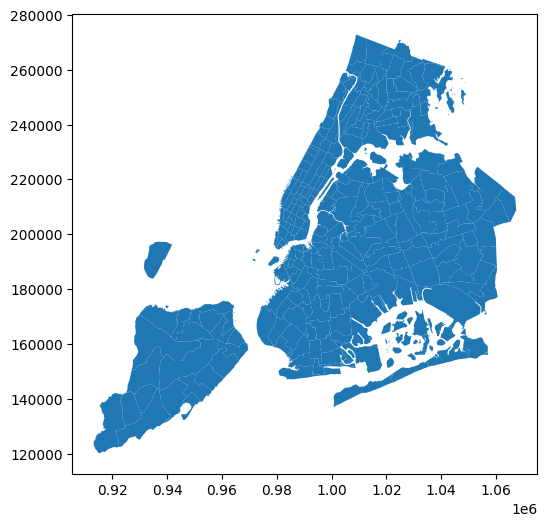

In [8]:
import geopandas as gpd
taxi_zones = gpd.read_file(r'/home/hungnq/hungnq_2/taxi_EDA/taxi_zone/taxi_zones.shp')
taxi_zones.info()
taxi_zones.plot(figsize=(6,6))
print(taxi_zones.columns.to_list())
taxi_zones.crs

In [12]:
taxi_zones = taxi_zones.to_crs(2263)
taxi_zones['centroid'] = taxi_zones.centroid
# project the centroids' locations to another coordinate system
taxi_zones = taxi_zones.to_crs(epsg=4326)
taxi_zones['centroid'] = taxi_zones['centroid'].to_crs(epsg=4326)
taxi_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroid
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",POINT (-74.17400 40.69183)
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",POINT (-73.83130 40.61675)
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.84742 40.86447)
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",POINT (-73.97697 40.72375)
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",POINT (-74.18848 40.55266)


In [13]:
taxi_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int64   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int64   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
 7   centroid    263 non-null    geometry
dtypes: float64(2), geometry(2), int64(2), object(2)
memory usage: 16.6+ KB


In [14]:
import folium

m1 = folium.Map(location=[40.70, -73.94], zoom_start=12)

# add centroid marker to each taxi zones
latitudes = []
longitudes = []
# markers_group = folium.FeatureGroup(name='Taxi Zones Centroids')
for _, r in taxi_zones.iterrows():
    lat = r['centroid'].y
    latitudes.append(lat)
    lon = r['centroid'].x
    longitudes.append(lon)
    folium.Marker(location=[lat, lon], popup='LocationID:{}<br>Zone:{}<br>Borough:{}'.format(r['LocationID'], r['zone'], r['borough']),icon=folium.Icon(icon='info-sign')).add_to(m1)

# project geometries on the map to locate precise regions of taxi zones
for _, r in taxi_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.0001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {'fillColor': 'green'})
    folium.Popup(r['zone']).add_to(geo_j)
    geo_j.add_to(m1)
    
# markers_group.add_to(m)
taxi_zones['c_latitude'] = latitudes
taxi_zones['c_longitude'] = longitudes
# m1.save('maps/taxi_zones.html') # save as html


### Feature Engineering
 

In [22]:
valid_date = pd.date_range(start="2023-06-01 00:00:00", end="2023-06-30 23:59:59", freq="1S")
valid_date[:10]

DatetimeIndex(['2023-06-01 00:00:00', '2023-06-01 00:00:01',
               '2023-06-01 00:00:02', '2023-06-01 00:00:03',
               '2023-06-01 00:00:04', '2023-06-01 00:00:05',
               '2023-06-01 00:00:06', '2023-06-01 00:00:07',
               '2023-06-01 00:00:08', '2023-06-01 00:00:09'],
              dtype='datetime64[ns]', freq='S')

#### fhvhv 
FHV data includes trip data from high-volume for-hire vehicle bases (bases for companies dispatching 10,000+ trip per day, meaning Uber, Lyft, Via, and Juno), community livery bases, luxury limousine bases, and black car bases.

=> Reason why PUlocationID and DOlocationID has high propability of null value because 
1. Maybe customer hiring vehicle want to keep information location ( hiring luxury limousine bases for billionaire, sercret meeting).
2. Hiring vehicle is different with calling taxi, using hired vehicle for any objectives is optional. (time to hire vehicle is recored but location's recored is optional)

That's why we choose to analysis **temporal** feature rather than **spacial** one.

In [8]:
fhvhv_tripdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219445 entries, 0 to 1219444
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1219445 non-null  object        
 1   pickup_datetime         1219445 non-null  datetime64[us]
 2   dropOff_datetime        1219445 non-null  datetime64[us]
 3   PUlocationID            295894 non-null   float64       
 4   DOlocationID            1044549 non-null  float64       
 5   SR_Flag                 0 non-null        float64       
 6   Affiliated_base_number  1219445 non-null  object        
dtypes: datetime64[us](2), float64(3), object(2)
memory usage: 65.1+ MB


##### cleaning
1. Because SR_Flag is fully none so I drop it
2. Rate of having Nan on location field of for-hired vehicle high volumn is very high, so we mainly use this dataset for time feature.

=> Objective, how many taxi for each type activate on NYC.

drop non-used feature, duplicates

In [9]:
clean_fhvhv_tripdata = fhvhv_tripdata.drop(columns=['SR_Flag', "Affiliated_base_number", "PUlocationID", "DOlocationID"])
clean_fhvhv_tripdata = clean_fhvhv_tripdata.drop_duplicates()
clean_fhvhv_tripdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1217868 entries, 0 to 1219444
Data columns (total 3 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   dispatching_base_num  1217868 non-null  object        
 1   pickup_datetime       1217868 non-null  datetime64[us]
 2   dropOff_datetime      1217868 non-null  datetime64[us]
dtypes: datetime64[us](2), object(1)
memory usage: 37.2+ MB


checkout each feature vehicle duplication

In [10]:
len(clean_fhvhv_tripdata['dispatching_base_num'].unique())

405

405 vehicles per 1219444 records => In one day, one vehicle can be hired multiple times.

In [11]:
len(clean_fhvhv_tripdata)

1217868

Validate time

In [12]:
# convert dates to datetime
clean_fhvhv_tripdata['pickup_datetime'] = pd.to_datetime(clean_fhvhv_tripdata['pickup_datetime'])
clean_fhvhv_tripdata['dropOff_datetime'] = pd.to_datetime(clean_fhvhv_tripdata['dropOff_datetime'])
clean_fhvhv_tripdata.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime
0,B00008,2023-06-01 00:00:00,2023-06-01 00:21:00
1,B00008,2023-06-01 00:15:00,2023-06-01 00:41:00
2,B00009,2023-06-01 00:00:00,2023-06-01 00:13:00
3,B00009,2023-06-01 00:15:00,2023-06-01 00:28:00
4,B00009,2023-06-01 00:30:00,2023-06-01 00:45:00


In [13]:
print('Earliest pickup datetime:', clean_fhvhv_tripdata['pickup_datetime'].min())
print('Latest pickup datetime:', clean_fhvhv_tripdata['pickup_datetime'].max())

Earliest pickup datetime: 2023-06-01 00:00:00
Latest pickup datetime: 2023-06-30 23:59:59


*Extra explore*: Number of samples having ability of cancelling hiring vehicle after pickup

In [14]:
clean_fhvhv_tripdata['hiring_time'] = clean_fhvhv_tripdata['dropOff_datetime'] - clean_fhvhv_tripdata['pickup_datetime']
clean_fhvhv_tripdata["hiring_time"].head()

0   0 days 00:21:00
1   0 days 00:26:00
2   0 days 00:13:00
3   0 days 00:13:00
4   0 days 00:15:00
Name: hiring_time, dtype: timedelta64[us]

In [15]:
cond = [clean_fhvhv_tripdata["hiring_time"].dt.total_seconds() < 300]
np.sum(cond)

89963

In [16]:
clean_fhvhv_tripdata[clean_fhvhv_tripdata["hiring_time"].dt.total_seconds() < 300][:10]

,dispatching_base_num,pickup_datetime,dropOff_datetime,hiring_time
7,B00112,2023-06-01 00:04:25,2023-06-01 00:04:29,0 days 00:00:04
10,B00149,2023-06-01 00:57:48,2023-06-01 01:01:04,0 days 00:03:16
18,B00225,2023-06-01 00:39:38,2023-06-01 00:41:37,0 days 00:01:59
22,B00254,2023-06-01 00:42:24,2023-06-01 00:45:43,0 days 00:03:19
42,B00271,2023-06-01 00:28:21,2023-06-01 00:31:42,0 days 00:03:21
44,B00310,2023-06-01 00:51:56,2023-06-01 00:55:31,0 days 00:03:35
47,B00310,2023-06-01 00:39:47,2023-06-01 00:43:09,0 days 00:03:22
80,B00706,2023-06-01 00:24:01,2023-06-01 00:24:16,0 days 00:00:15
91,B00789,2023-06-01 00:38:14,2023-06-01 00:39:00,0 days 00:00:46
102,B00837,2023-06-01 00:10:35,2023-06-01 00:10:36,0 days 00:00:01


#### Green taxi
Green taxis, also known as boro taxis and street-hail liveries, were introduced in August of 2013 to improve taxi service and availability in the boroughs. Green taxis may respond to street hails, but only in the areas indicated in green on the map (i.e. above W 110 St/E 96th St in Manhattan and in the boroughs).

In [15]:
green_tripdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65550 entries, 0 to 65549
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               65550 non-null  int32         
 1   lpep_pickup_datetime   65550 non-null  datetime64[us]
 2   lpep_dropoff_datetime  65550 non-null  datetime64[us]
 3   store_and_fwd_flag     60359 non-null  object        
 4   RatecodeID             60359 non-null  float64       
 5   PULocationID           65550 non-null  int32         
 6   DOLocationID           65550 non-null  int32         
 7   passenger_count        60359 non-null  float64       
 8   trip_distance          65550 non-null  float64       
 9   fare_amount            65550 non-null  float64       
 10  extra                  65550 non-null  float64       
 11  mta_tax                65550 non-null  float64       
 12  tip_amount             65550 non-null  float64       
 13  t

##### cleaning

Records which not sending to vendor canbe invalid trip => indicate that `store_and_fwd_flag` has null value. 

=> leading to `payment_type`, `trip_type`, `congestion_surcharge`, `passenger_count`, `RatecodeID` values are null

=> drop nan

In [40]:
clean_green_tripdata = green_tripdata.drop(columns=['ehail_fee'])
len(clean_green_tripdata)

65550

In [41]:
time_location_green_data = clean_green_tripdata.drop(columns=["fare_amount", "extra", "mta_tax","tip_amount", "trip_type", "store_and_fwd_flag",
                                                             "tolls_amount", "improvement_surcharge", "total_amount", "RatecodeID", "trip_distance",
                                                             "payment_type", "trip_type", "passenger_count", "congestion_surcharge"])
time_location_green_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID
0,2,2023-06-01 00:32:25,2023-06-01 00:39:06,74,42
1,2,2023-06-01 00:39:07,2023-06-01 00:51:59,41,229
2,2,2023-06-01 00:35:59,2023-06-01 00:57:06,97,89
3,2,2023-06-01 00:50:29,2023-06-01 01:00:32,75,263
4,2,2023-06-01 00:15:15,2023-06-01 00:52:40,33,48


##### validate time

In [42]:
# convert dates to datetime
time_location_green_data['pickup_datetime'] = pd.to_datetime(time_location_green_data['lpep_pickup_datetime'])
time_location_green_data['dropOff_datetime'] = pd.to_datetime(time_location_green_data['lpep_dropoff_datetime'])
time_location_green_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,pickup_datetime,dropOff_datetime
0,2,2023-06-01 00:32:25,2023-06-01 00:39:06,74,42,2023-06-01 00:32:25,2023-06-01 00:39:06
1,2,2023-06-01 00:39:07,2023-06-01 00:51:59,41,229,2023-06-01 00:39:07,2023-06-01 00:51:59
2,2,2023-06-01 00:35:59,2023-06-01 00:57:06,97,89,2023-06-01 00:35:59,2023-06-01 00:57:06
3,2,2023-06-01 00:50:29,2023-06-01 01:00:32,75,263,2023-06-01 00:50:29,2023-06-01 01:00:32
4,2,2023-06-01 00:15:15,2023-06-01 00:52:40,33,48,2023-06-01 00:15:15,2023-06-01 00:52:40


In [43]:
print('Earliest pickup datetime:', time_location_green_data['pickup_datetime'].min())
print('Latest pickup datetime:', time_location_green_data['pickup_datetime'].max())

Earliest pickup datetime: 2023-05-26 01:58:10
Latest pickup datetime: 2023-07-01 23:59:30


In [44]:
time_location_green_data = time_location_green_data[time_location_green_data["pickup_datetime"].isin(valid_date)]
time_location_green_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65538 entries, 0 to 65549
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               65538 non-null  int32         
 1   lpep_pickup_datetime   65538 non-null  datetime64[us]
 2   lpep_dropoff_datetime  65538 non-null  datetime64[us]
 3   PULocationID           65538 non-null  int32         
 4   DOLocationID           65538 non-null  int32         
 5   pickup_datetime        65538 non-null  datetime64[us]
 6   dropOff_datetime       65538 non-null  datetime64[us]
dtypes: datetime64[us](4), int32(3)
memory usage: 3.3 MB


Having 12 samples is not in valid month (July)

In [45]:
time_location_green_data = time_location_green_data.drop(columns=["lpep_pickup_datetime", "lpep_dropoff_datetime"])
time_location_green_data.head()

,VendorID,PULocationID,DOLocationID,pickup_datetime,dropOff_datetime
0,2,74,42,2023-06-01 00:32:25,2023-06-01 00:39:06
1,2,41,229,2023-06-01 00:39:07,2023-06-01 00:51:59
2,2,97,89,2023-06-01 00:35:59,2023-06-01 00:57:06
3,2,75,263,2023-06-01 00:50:29,2023-06-01 01:00:32
4,2,33,48,2023-06-01 00:15:15,2023-06-01 00:52:40


##### validate location

In [47]:
time_location_green_data = pd.merge(time_location_green_data, taxi_zones, how='left',left_on='PULocationID',right_on='LocationID', suffixes=('_PU', '_DO')).drop(columns=['PULocationID'])
time_location_green_data = pd.merge(time_location_green_data, taxi_zones, how='left',left_on='DOLocationID',right_on='LocationID', suffixes=('_PU', '_DO')).drop(columns=['DOLocationID'])
# clean_green_tripdata['PUZone']
time_location_green_data.head()

,VendorID,pickup_datetime,dropOff_datetime,OBJECTID_PU,Shape_Leng_PU,Shape_Area_PU,zone_PU,LocationID_PU,borough_PU,geometry_PU,centroid_PU,c_latitude_PU,c_longitude_PU,OBJECTID_DO,Shape_Leng_DO,Shape_Area_DO,zone_DO,LocationID_DO,borough_DO,geometry_DO,centroid_DO,c_latitude_DO,c_longitude_DO
0,2,2023-06-01 00:32:25,2023-06-01 00:39:06,74.0,0.110291,0.000295,East Harlem North,74.0,Manhattan,"MULTIPOLYGON (((-73.93381 40.81651, -73.93383 ...",POINT (-73.93735 40.80117),40.801169,-73.937346,42.0,0.092709,0.000264,Central Harlem North,42.0,Manhattan,"POLYGON ((-73.93436 40.83620, -73.93445 40.835...",POINT (-73.94077 40.81826),40.818257,-73.940772
1,2,2023-06-01 00:39:07,2023-06-01 00:51:59,41.0,0.052793,0.000143,Central Harlem,41.0,Manhattan,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",POINT (-73.95129 40.80433),40.804334,-73.951292,229.0,0.042525,0.000095,Sutton Place/Turtle Bay North,229.0,Manhattan,"POLYGON ((-73.96163 40.75515, -73.96219 40.754...",POINT (-73.96515 40.75673),40.756729,-73.965146
2,2,2023-06-01 00:35:59,2023-06-01 00:57:06,97.0,0.062476,0.000163,Fort Greene,97.0,Brooklyn,"POLYGON ((-73.96934 40.69577, -73.96881 40.693...",POINT (-73.97488 40.69079),40.690787,-73.974882,89.0,0.122795,0.000448,Flatbush/Ditmas Park,89.0,Brooklyn,"POLYGON ((-73.95375 40.63859, -73.95360 40.638...",POINT (-73.96097 40.63790),40.637900,-73.960968
3,2,2023-06-01 00:50:29,2023-06-01 01:00:32,75.0,0.087664,0.000241,East Harlem South,75.0,Manhattan,"POLYGON ((-73.94103 40.79255, -73.93865 40.791...",POINT (-73.94575 40.79001),40.790011,-73.945750,263.0,0.037017,0.000066,Yorkville West,263.0,Manhattan,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",POINT (-73.95101 40.77877),40.778766,-73.951010
4,2,2023-06-01 00:15:15,2023-06-01 00:52:40,33.0,0.053270,0.000147,Brooklyn Heights,33.0,Brooklyn,"POLYGON ((-73.99619 40.70338, -73.99514 40.702...",POINT (-73.99525 40.69580),40.695798,-73.995250,48.0,0.043747,0.000094,Clinton East,48.0,Manhattan,"POLYGON ((-73.99118 40.75533, -73.99163 40.754...",POINT (-73.98984 40.76225),40.762253,-73.989845


In [48]:
time_location_green_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65958 entries, 0 to 65957
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   VendorID          65958 non-null  int32         
 1   pickup_datetime   65958 non-null  datetime64[us]
 2   dropOff_datetime  65958 non-null  datetime64[us]
 3   OBJECTID_PU       65725 non-null  float64       
 4   Shape_Leng_PU     65725 non-null  float64       
 5   Shape_Area_PU     65725 non-null  float64       
 6   zone_PU           65725 non-null  object        
 7   LocationID_PU     65725 non-null  float64       
 8   borough_PU        65725 non-null  object        
 9   geometry_PU       65725 non-null  geometry      
 10  centroid_PU       65725 non-null  geometry      
 11  c_latitude_PU     65725 non-null  float64       
 12  c_longitude_PU    65725 non-null  float64       
 13  OBJECTID_DO       65066 non-null  float64       
 14  Shape_Leng_DO     6506

In [49]:
len(time_location_green_data[(time_location_green_data["LocationID_PU"] == 265) | (time_location_green_data["LocationID_PU"] == 264) | 
                            (time_location_green_data["LocationID_DO"] == 265) | (time_location_green_data["LocationID_DO"] == 264)])

0

In [50]:
cleanlocate_green_data_td = time_location_green_data[(time_location_green_data["LocationID_PU"] != 265) & (time_location_green_data["LocationID_PU"] !=  264) &
                         (time_location_green_data["LocationID_DO"] !=  265) & (time_location_green_data["LocationID_DO"] !=  264)]
cleanlocate_green_data_td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65958 entries, 0 to 65957
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   VendorID          65958 non-null  int32         
 1   pickup_datetime   65958 non-null  datetime64[us]
 2   dropOff_datetime  65958 non-null  datetime64[us]
 3   OBJECTID_PU       65725 non-null  float64       
 4   Shape_Leng_PU     65725 non-null  float64       
 5   Shape_Area_PU     65725 non-null  float64       
 6   zone_PU           65725 non-null  object        
 7   LocationID_PU     65725 non-null  float64       
 8   borough_PU        65725 non-null  object        
 9   geometry_PU       65725 non-null  geometry      
 10  centroid_PU       65725 non-null  geometry      
 11  c_latitude_PU     65725 non-null  float64       
 12  c_longitude_PU    65725 non-null  float64       
 13  OBJECTID_DO       65066 non-null  float64       
 14  Shape_Leng_DO     6506

0 samples have invalid location

drop unused columns and missing location value

In [37]:
time_location_green_data.keys()

Index(['VendorID', 'pickup_datetime', 'dropOff_datetime', 'OBJECTID_PU',
       'Shape_Leng_PU', 'Shape_Area_PU', 'zone_PU', 'LocationID_PU',
       'borough_PU', 'geometry_PU', 'centroid_PU', 'c_latitude_PU',
       'c_longitude_PU', 'OBJECTID_DO', 'Shape_Leng_DO', 'Shape_Area_DO',
       'zone_DO', 'LocationID_DO', 'borough_DO', 'geometry_DO', 'centroid_DO',
       'c_latitude_DO', 'c_longitude_DO'],
      dtype='object')

In [51]:
time_location_green_data = time_location_green_data.drop(columns=[
    'OBJECTID_DO',
    'Shape_Leng_DO', 
    'Shape_Area_DO',
    'OBJECTID_PU',
    'Shape_Area_PU', 
    'Shape_Leng_PU'])
final_time_location_green_data = time_location_green_data.dropna()
final_time_location_green_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64995 entries, 0 to 65957
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   VendorID          64995 non-null  int32         
 1   pickup_datetime   64995 non-null  datetime64[us]
 2   dropOff_datetime  64995 non-null  datetime64[us]
 3   zone_PU           64995 non-null  object        
 4   LocationID_PU     64995 non-null  float64       
 5   borough_PU        64995 non-null  object        
 6   geometry_PU       64995 non-null  geometry      
 7   centroid_PU       64995 non-null  geometry      
 8   c_latitude_PU     64995 non-null  float64       
 9   c_longitude_PU    64995 non-null  float64       
 10  zone_DO           64995 non-null  object        
 11  LocationID_DO     64995 non-null  float64       
 12  borough_DO        64995 non-null  object        
 13  geometry_DO       64995 non-null  geometry      
 14  centroid_DO       64995 non

drop ~ 1k nan samples

#### yellow taxi
Yellow taxis are traditionally hailed by signaling to a driver who is on duty and seeking a passenger (street hail), but now they may also be hailed using an e-hail app like Curb or Arro. Yellow taxis are the only vehicles permitted to respond to a street hail from a passenger in all five boroughs.


In [52]:
yellow_tripdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307234 entries, 0 to 3307233
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [53]:
yellow_tripdata = yellow_tripdata.drop_duplicates()
yellow_tripdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307234 entries, 0 to 3307233
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

##### validate time

In [54]:
yellow_tripdata.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-01 00:08:48,2023-06-01 00:29:41,1.0,3.40,1.0,N,140,238,1,21.9,3.50,0.5,6.70,0.0,1.0,33.60,2.5,0.00
1,1,2023-06-01 00:15:04,2023-06-01 00:25:18,0.0,3.40,1.0,N,50,151,1,15.6,3.50,0.5,3.00,0.0,1.0,23.60,2.5,0.00
2,1,2023-06-01 00:48:24,2023-06-01 01:07:07,1.0,10.20,1.0,N,138,97,1,40.8,7.75,0.5,10.00,0.0,1.0,60.05,0.0,1.75
3,2,2023-06-01 00:54:03,2023-06-01 01:17:29,3.0,9.83,1.0,N,100,244,1,39.4,1.00,0.5,8.88,0.0,1.0,53.28,2.5,0.00
4,2,2023-06-01 00:18:44,2023-06-01 00:27:18,1.0,1.17,1.0,N,137,234,1,9.3,1.00,0.5,0.72,0.0,1.0,15.02,2.5,0.00


In [56]:
print('Earliest pickup datetime:', yellow_tripdata['tpep_pickup_datetime'].min())
print('Latest pickup datetime:', yellow_tripdata['tpep_pickup_datetime'].max())

Earliest pickup datetime: 2002-12-31 23:03:19
Latest pickup datetime: 2023-07-01 00:42:13


Having invalid recores (2002 and record of July) 

In [57]:
yellow_tripdata = yellow_tripdata[yellow_tripdata["tpep_pickup_datetime"].isin(valid_date)]
yellow_tripdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3307193 entries, 0 to 3307233
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            floa

Remove 40 samples

##### validate location

In [58]:
time_location_yello_data = yellow_tripdata.drop(columns=["VendorID", "passenger_count", "RatecodeID","payment_type", "fare_amount", "store_and_fwd_flag",
                                                             "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "trip_distance",
                                                             "total_amount", "congestion_surcharge", "Airport_fee"])
time_location_yello_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3307193 entries, 0 to 3307233
Data columns (total 4 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   PULocationID           int32         
 3   DOLocationID           int32         
dtypes: datetime64[us](2), int32(2)
memory usage: 100.9 MB


In [59]:
time_location_yello_data = pd.merge(time_location_yello_data, taxi_zones, how='left',left_on='PULocationID',right_on='LocationID', suffixes=('_PU', '_DO')).drop(columns=['PULocationID'])
time_location_yello_data = pd.merge(time_location_yello_data, taxi_zones, how='left',left_on='DOLocationID',right_on='LocationID', suffixes=('_PU', '_DO')).drop(columns=['DOLocationID'])
# clean_green_tripdata['PUZone']
time_location_yello_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,OBJECTID_PU,Shape_Leng_PU,Shape_Area_PU,zone_PU,LocationID_PU,borough_PU,geometry_PU,centroid_PU,c_latitude_PU,c_longitude_PU,OBJECTID_DO,Shape_Leng_DO,Shape_Area_DO,zone_DO,LocationID_DO,borough_DO,geometry_DO,centroid_DO,c_latitude_DO,c_longitude_DO
0,2023-06-01 00:08:48,2023-06-01 00:29:41,140.0,0.047584,0.000114,Lenox Hill East,140.0,Manhattan,"POLYGON ((-73.95854 40.75850, -73.95878 40.758...",POINT (-73.95474 40.76548),40.765484,-73.954739,238.0,0.060109,0.000185,Upper West Side North,238.0,Manhattan,"POLYGON ((-73.96884 40.78597, -73.96934 40.785...",POINT (-73.97305 40.79170),40.791705,-73.973049
1,2023-06-01 00:15:04,2023-06-01 00:25:18,50.0,0.055748,0.000173,Clinton West,50.0,Manhattan,"POLYGON ((-73.99668 40.77351, -73.99434 40.772...",POINT (-73.99514 40.76624),40.766238,-73.995135,151.0,0.054890,0.000129,Manhattan Valley,151.0,Manhattan,"POLYGON ((-73.96371 40.79301, -73.96418 40.792...",POINT (-73.96817 40.79796),40.797962,-73.968168
2,2023-06-01 00:48:24,2023-06-01 01:07:07,138.0,0.107467,0.000537,LaGuardia Airport,138.0,Queens,"MULTIPOLYGON (((-73.87125 40.78604, -73.86978 ...",POINT (-73.87363 40.77438),40.774376,-73.873628,97.0,0.062476,0.000163,Fort Greene,97.0,Brooklyn,"POLYGON ((-73.96934 40.69577, -73.96881 40.693...",POINT (-73.97488 40.69079),40.690787,-73.974882
3,2023-06-01 00:54:03,2023-06-01 01:17:29,100.0,0.024813,0.000037,Garment District,100.0,Manhattan,"POLYGON ((-73.98729 40.75045, -73.98777 40.749...",POINT (-73.98879 40.75351),40.753513,-73.988787,244.0,0.080569,0.000360,Washington Heights South,244.0,Manhattan,"POLYGON ((-73.94069 40.85132, -73.94069 40.851...",POINT (-73.94140 40.84171),40.841708,-73.941399
4,2023-06-01 00:18:44,2023-06-01 00:27:18,137.0,0.046108,0.000116,Kips Bay,137.0,Manhattan,"POLYGON ((-73.97220 40.74040, -73.97222 40.740...",POINT (-73.97649 40.74044),40.740439,-73.976495,234.0,0.036072,0.000073,Union Sq,234.0,Manhattan,"POLYGON ((-73.98997 40.73490, -73.98990 40.734...",POINT (-73.99046 40.74034),40.740337,-73.990458


In [60]:
len(time_location_yello_data[(time_location_yello_data["LocationID_PU"] == 265) | (time_location_yello_data["LocationID_PU"] == 264) | 
                         (time_location_yello_data["LocationID_DO"] == 265) | (time_location_yello_data["LocationID_DO"] == 264)])

0

having 34102 invalid location values 

In [62]:
cleanlocate_yellow_data_td = time_location_yello_data[(time_location_yello_data["LocationID_PU"] != 265) & (time_location_yello_data["LocationID_PU"] !=  264) &
                         (time_location_yello_data["LocationID_DO"] !=  265) & (time_location_yello_data["LocationID_DO"] !=  264)]
cleanlocate_yellow_data_td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3308330 entries, 0 to 3308329
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   OBJECTID_PU            float64       
 3   Shape_Leng_PU          float64       
 4   Shape_Area_PU          float64       
 5   zone_PU                object        
 6   LocationID_PU          float64       
 7   borough_PU             object        
 8   geometry_PU            geometry      
 9   centroid_PU            geometry      
 10  c_latitude_PU          float64       
 11  c_longitude_PU         float64       
 12  OBJECTID_DO            float64       
 13  Shape_Leng_DO          float64       
 14  Shape_Area_DO          float64       
 15  zone_DO                object        
 16  LocationID_DO          float64       
 17  borough_DO             object        
 18  geometry_DO           

In [63]:
cleanlocate_yellow_data_td = cleanlocate_yellow_data_td.drop(columns=[
    "OBJECTID_PU",
    "Shape_Leng_PU",
    "Shape_Area_PU",
    "OBJECTID_DO",
    "Shape_Leng_DO",
    "Shape_Area_DO"
])
final_time_location_yellow_data = cleanlocate_yellow_data_td.dropna()
final_time_location_yellow_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3251126 entries, 0 to 3308329
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   zone_PU                object        
 3   LocationID_PU          float64       
 4   borough_PU             object        
 5   geometry_PU            geometry      
 6   centroid_PU            geometry      
 7   c_latitude_PU          float64       
 8   c_longitude_PU         float64       
 9   zone_DO                object        
 10  LocationID_DO          float64       
 11  borough_DO             object        
 12  geometry_DO            geometry      
 13  centroid_DO            geometry      
 14  c_latitude_DO          float64       
 15  c_longitude_DO         float64       
dtypes: datetime64[us](2), float64(6), geometry(4), object(4)
memory usage: 421.7+ MB


### temporal-spatial visualization

#### Plot spatial with taxi car
1. yellow taxi
2. green taxi

##### prepare latitude and longtitude

In [48]:
final_time_location_green_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,pickup_datetime,dropOff_datetime,LocationID_PU,Borough_PU,Zone_PU,service_zone_PU,LocationID_DO,Borough_DO,Zone_DO,service_zone_DO
0,2,2023-06-01 00:32:25,2023-06-01 00:39:06,2023-06-01 00:32:25,2023-06-01 00:39:06,74,Manhattan,East Harlem North,Boro Zone,42,Manhattan,Central Harlem North,Boro Zone
1,2,2023-06-01 00:39:07,2023-06-01 00:51:59,2023-06-01 00:39:07,2023-06-01 00:51:59,41,Manhattan,Central Harlem,Boro Zone,229,Manhattan,Sutton Place/Turtle Bay North,Yellow Zone
2,2,2023-06-01 00:35:59,2023-06-01 00:57:06,2023-06-01 00:35:59,2023-06-01 00:57:06,97,Brooklyn,Fort Greene,Boro Zone,89,Brooklyn,Flatbush/Ditmas Park,Boro Zone
3,2,2023-06-01 00:50:29,2023-06-01 01:00:32,2023-06-01 00:50:29,2023-06-01 01:00:32,75,Manhattan,East Harlem South,Boro Zone,263,Manhattan,Yorkville West,Yellow Zone
4,2,2023-06-01 00:15:15,2023-06-01 00:52:40,2023-06-01 00:15:15,2023-06-01 00:52:40,33,Brooklyn,Brooklyn Heights,Boro Zone,48,Manhattan,Clinton East,Yellow Zone


get the latitude, longtitude of each zone where taxi pickup and dropoff passanger

In [64]:
final_time_location_green_data['c_latitude_PU'].max()

40.89952838046223

In [174]:
# from geopandas import GeoDataFrame
# import geopandas as gpd
# from shapely.geometry import Point

# fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize = (15,15))

# # fig, ax = plt.subplots(figsize=(15,15))

# nyc = gpd.read_file('/home/hungnq/hungnq/taxi_EDA/nyc_map/nyu_2451_34561.shp')
# nyc.plot(ax=ax[0])
# nyc.plot(ax=ax[1])

# # ax.scatter(processed_green_data['c_longitude_PU'].values, processed_green_data['c_latitude_PU'].values, color='red', s=1, label='train')
# ax[0].scatter(processed_green_data['c_longitude_PU'].values, processed_green_data['c_latitude_PU'].values, color='red', s=1, label='train')
# ax[1].scatter(processed_green_data['c_longitude_DO'].values, processed_green_data['c_latitude_DO'].values, color='red', s=1, label='train')

# ax[0].set_title('Pick-up Co-ordinates Green taxi')
# ax[1].set_title('Drop-off Co-ordinates Green taxi')

# ax[0].set_ylabel('Latitude')
# ax[0].set_xlabel('Longitude')
# ax[1].set_ylabel('Latitude')
# ax[1].set_xlabel('Longitude')

# # geometry_PU = [Point(x, y) for x, y in zip(processed_green_data['c_longitude_PU'], processed_green_data['c_latitude_PU'])]

# geometry_PU = [Point(x,y) for x,y in zip(processed_green_data['c_longitude_PU'], processed_green_data['c_latitude_PU'])]
# geometry_DO = [Point(x,y) for x,y in zip(processed_green_data['c_longitude_DO'], processed_green_data['c_latitude_DO'])]


# gdf_PU = GeoDataFrame(processed_green_data, geometry=geometry_PU)
# gdf_DO = GeoDataFrame(processed_green_data, geometry=geometry_DO)

# gdf_PU.plot(ax=ax[0], markersize=20, color='red', marker='o')
# gdf_DO.plot(ax=ax[1],markersize=20, color='green', marker='o')


In [175]:
# fig_2, ax_2 = plt.subplots(ncols=2, sharex=True, sharey=True, figsize = (15,15))

# nyc_2 = gpd.read_file('/home/hungnq/hungnq/taxi_EDA/nyc_map/nyu_2451_34561.shp')
# nyc_2.plot(ax=ax_2[0])

# ax_2[0].scatter(processed_yello_data['c_longitude_PU'].values, processed_yello_data['c_latitude_PU'].values, color='red', s=1, label='train')
# ax_2[1].scatter(processed_yello_data['c_longitude_DO'].values, processed_yello_data['c_latitude_DO'].values, color='red', s=1, label='train')

In [176]:
# fig_2, ax_2 = plt.subplots(ncols=2, sharex=True, sharey=True, figsize = (15,15))

# ax_2[0].scatter(processed_yello_data['c_longitude_PU'].values, processed_yello_data['c_latitude_PU'].values, color='red', s=1, label='train')
# ax_2[1].scatter(processed_yello_data['c_longitude_DO'].values, processed_yello_data['c_latitude_DO'].values, color='red', s=1, label='train')

# nyc_2 = gpd.read_file('/home/hungnq/hungnq/taxi_EDA/nyc_map/nyu_2451_34561.shp')
# nyc_2.plot(ax=ax_2[0])
# nyc_2.plot(ax=ax_2[1])

# ax_2[0].set_title('Pick-up Co-ordinates Yellow taxi')
# ax_2[1].set_title('Drop-off Co-ordinates Yellow taxi')

# ax_2[0].set_ylabel('Latitude')
# ax_2[0].set_xlabel('Longitude')
# ax_2[1].set_ylabel('Latitude')
# ax_2[1].set_xlabel('Longitude')

# geometry_PU_2 = [Point(x,y) for x,y in zip(processed_yello_data['c_longitude_PU'], processed_yello_data['c_latitude_PU'])]
# geometry_DO_2 = [Point(x,y) for x,y in zip(processed_yello_data['c_longitude_DO'], processed_yello_data['c_latitude_DO'])]

# gdf_PU_2 = GeoDataFrame(processed_yello_data, geometry=geometry_PU_2)
# gdf_DO_2 = GeoDataFrame(processed_yello_data, geometry=geometry_DO_2)

# gdf_PU_2.plot(ax=ax_2[0],markersize=20, color='red', marker='o')
# gdf_DO_2.plot(ax=ax_2[1],markersize=20, color='green', marker='o')

##### density map

In [67]:
import copy
from matplotlib.colors import LogNorm
def density_map(df, center, bins=1000, radius=0.35, title="Yellow taxi"):  
    cmap = copy.copy(plt.cm.jet)
    
    # Center the map around the provided center coordinates
    histogram_range = [
        [center[1] - radius, center[1] + radius],
        [center[0] - radius, center[0] + radius]
    ]
    
    fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize = (20,15))

    nyc = gpd.read_file('/home/hungnq/hungnq_2/taxi_EDA/nyc_map/nyu_2451_34561.shp')
    nyc.plot(ax=ax[0])
    nyc.plot(ax=ax[1])

    ax[0].set_title(f'Pick-up Co-ordinates {title}')
    ax[1].set_title(f'Drop-off Co-ordinates {title}')

    ax[0].set_ylabel('Latitude')
    ax[0].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_xlabel('Longitude')

    hh_PU = ax[0].hist2d(df["c_longitude_PU"], df["c_latitude_PU"], bins=bins, norm=LogNorm(),
               cmap=cmap, range=histogram_range)
    hh_DO = ax[1].hist2d(df["c_longitude_DO"], df["c_latitude_DO"], bins=bins, norm=LogNorm(),
               cmap=cmap, range=histogram_range)
    fig.colorbar(hh_PU[3],shrink=0.5)
    fig.colorbar(hh_DO[3],shrink=0.5)

    plt.show()

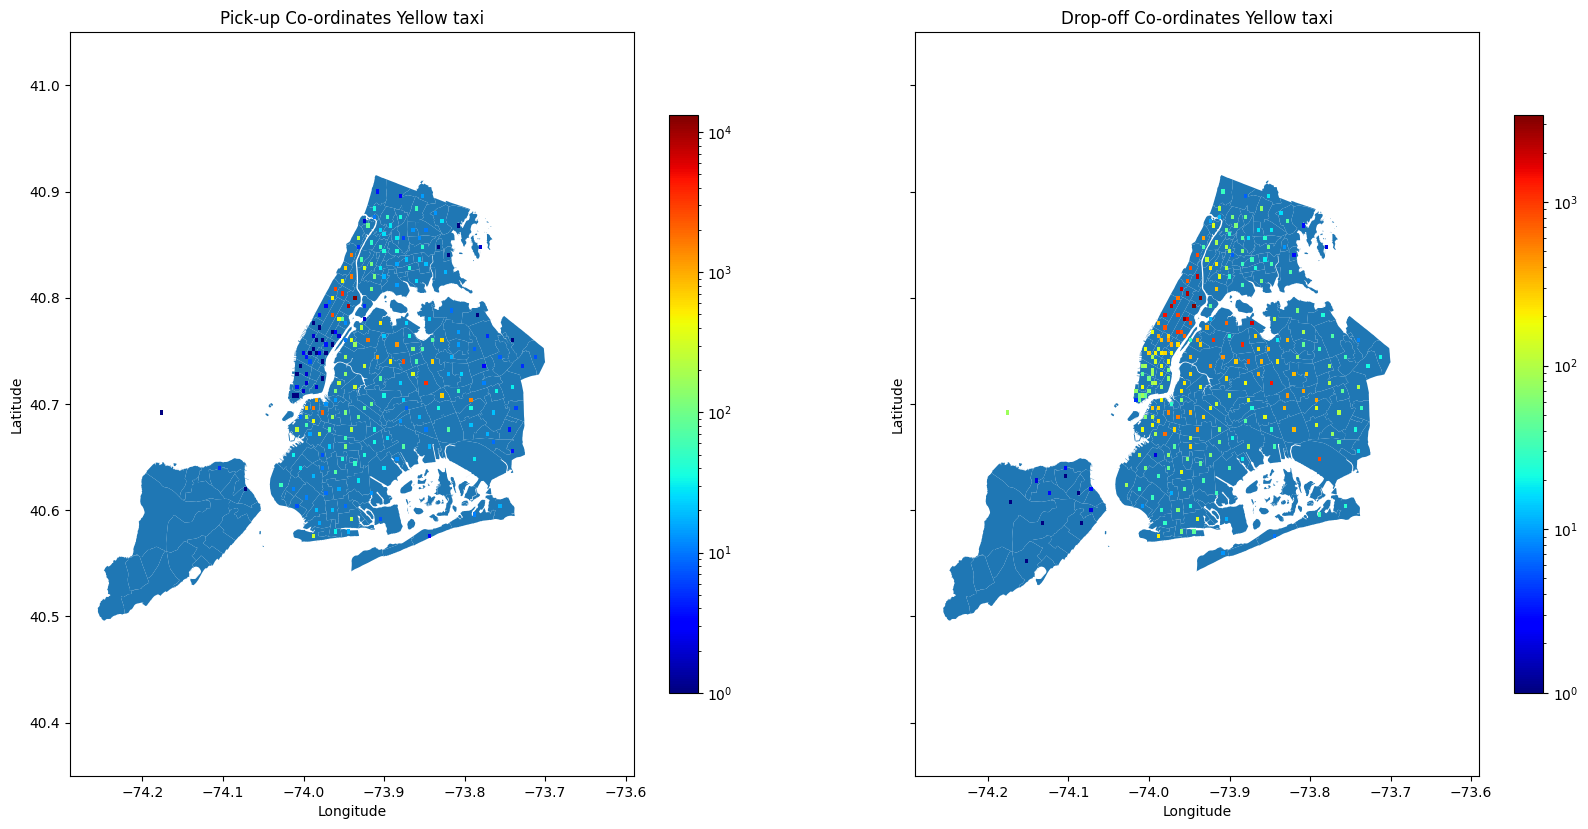

In [68]:
density_map(final_time_location_yellow_data, center=[40.70, -73.94], bins=175, title="Yellow taxi")

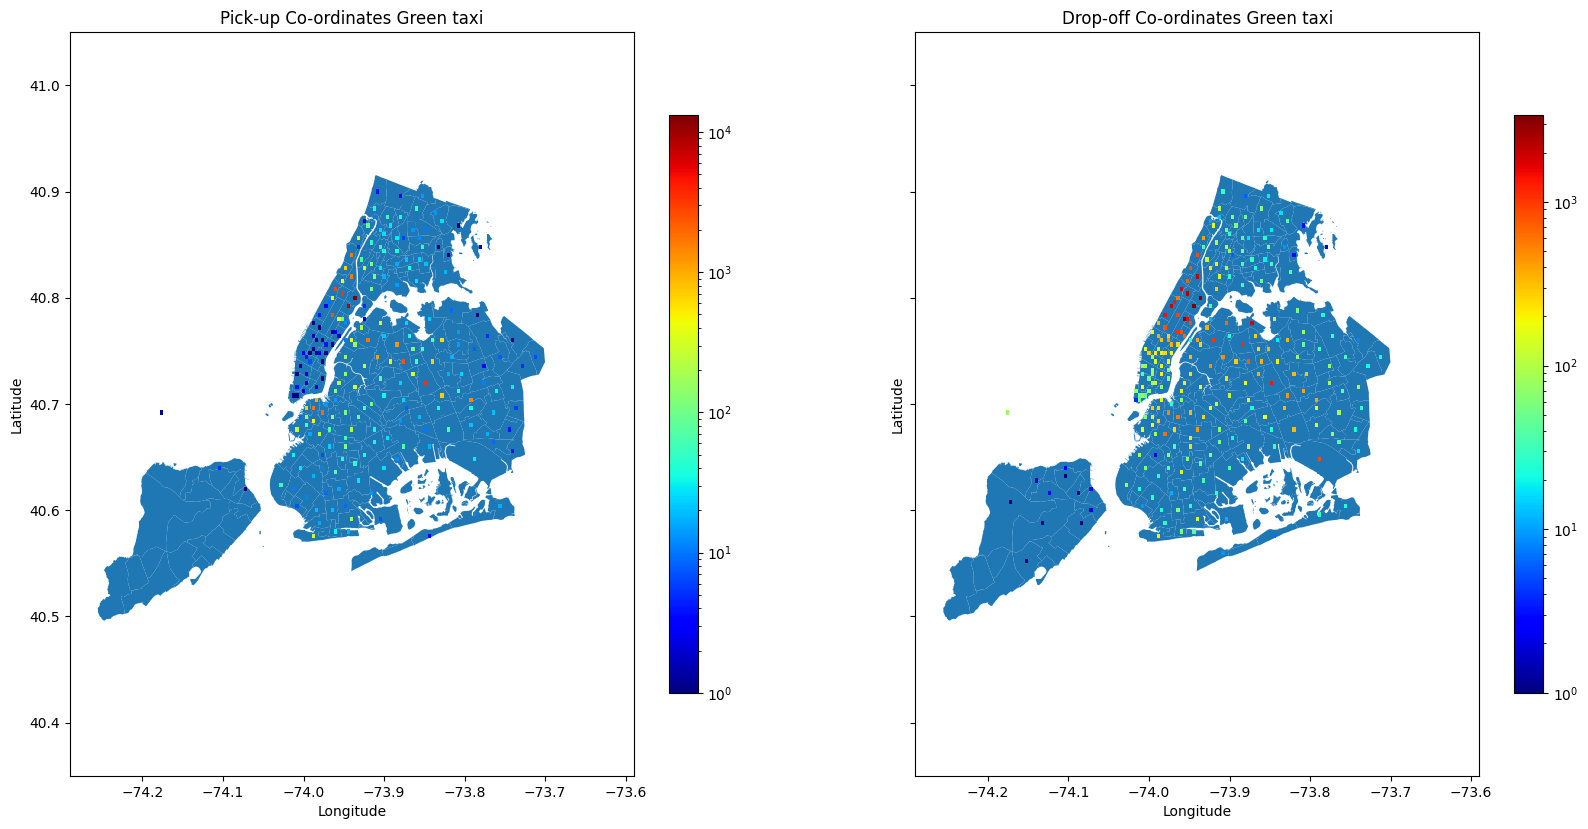

In [69]:
density_map(final_time_location_green_data, center=[40.70, -73.94], bins=175, title="Green taxi")

1. yellow taxi pickup mainly on Manhattan
2. Green taxi pickup mainly on Queen and Brooklyn

#### plot temporal data

In [70]:
def cluster_kmeans(df, n_clusters, n_init):
    longitude = list(df.c_longitude_PU) + list(df.c_longitude_DO)
    latitude = list(df.c_latitude_PU) + list(df.c_latitude_DO)
    loc_df = pd.DataFrame()
    loc_df['longitude'] = longitude
    loc_df['latitude'] = latitude
    
    kmeans = KMeans(n_clusters = n_clusters, n_init=n_init, random_state=123)
    kmeans.fit(loc_df)
    df['pick_cl'] = kmeans.labels_[:df.shape[0]]
    df['drop_cl'] = kmeans.labels_[df.shape[0]:]
    centroid_pick = pd.DataFrame(kmeans.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
    centroid_pick['pick_cl'] = centroid_pick.index
    centroid_drop = pd.DataFrame(kmeans.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
    centroid_drop['drop_cl'] = centroid_drop.index
    df_cl = pd.merge(df, centroid_pick, how = 'left', left_on = 'pick_cl', right_on = 'pick_cl')
    df_cl = pd.merge(df_cl, centroid_drop, how = 'left', left_on = 'drop_cl', right_on = 'drop_cl')
    return df_cl, kmeans, centroid_pick

In [71]:
# # must dropna before run
# processed_green_data = processed_green_data.dropna()
# kmeans cluster
cl_green_df, kmeans_green, centroid_green = cluster_kmeans(
    df=final_time_location_green_data, 
    n_clusters=15, 
    n_init=10)
cl_green_df.head()

/tmp/ipykernel_728/337123698.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pick_cl'] = kmeans.labels_[:df.shape[0]]
/tmp/ipykernel_728/337123698.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['drop_cl'] = kmeans.labels_[df.shape[0]:]


,VendorID,pickup_datetime,dropOff_datetime,zone_PU,LocationID_PU,borough_PU,geometry_PU,centroid_PU,c_latitude_PU,c_longitude_PU,zone_DO,LocationID_DO,borough_DO,geometry_DO,centroid_DO,c_latitude_DO,c_longitude_DO,pick_cl,drop_cl,centroid_pick_long,centroid_pick_lat,centroid_drop_long,centroid_drop_lat
0,2,2023-06-01 00:32:25,2023-06-01 00:39:06,East Harlem North,74.0,Manhattan,"MULTIPOLYGON (((-73.93381 40.81651, -73.93383 ...",POINT (-73.93735 40.80117),40.801169,-73.937346,Central Harlem North,42.0,Manhattan,"POLYGON ((-73.93436 40.83620, -73.93445 40.835...",POINT (-73.94077 40.81826),40.818257,-73.940772,4,12,-73.940457,40.796700,-73.952553,40.811237
1,2,2023-06-01 00:39:07,2023-06-01 00:51:59,Central Harlem,41.0,Manhattan,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",POINT (-73.95129 40.80433),40.804334,-73.951292,Sutton Place/Turtle Bay North,229.0,Manhattan,"POLYGON ((-73.96163 40.75515, -73.96219 40.754...",POINT (-73.96515 40.75673),40.756729,-73.965146,12,0,-73.952553,40.811237,-73.980781,40.745330
2,2,2023-06-01 00:35:59,2023-06-01 00:57:06,Fort Greene,97.0,Brooklyn,"POLYGON ((-73.96934 40.69577, -73.96881 40.693...",POINT (-73.97488 40.69079),40.690787,-73.974882,Flatbush/Ditmas Park,89.0,Brooklyn,"POLYGON ((-73.95375 40.63859, -73.95360 40.638...",POINT (-73.96097 40.63790),40.637900,-73.960968,5,10,-73.985313,40.690321,-73.970460,40.601610
3,2,2023-06-01 00:50:29,2023-06-01 01:00:32,East Harlem South,75.0,Manhattan,"POLYGON ((-73.94103 40.79255, -73.93865 40.791...",POINT (-73.94575 40.79001),40.790011,-73.945750,Yorkville West,263.0,Manhattan,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",POINT (-73.95101 40.77877),40.778766,-73.951010,4,2,-73.940457,40.796700,-73.964369,40.781084
4,2,2023-06-01 00:15:15,2023-06-01 00:52:40,Brooklyn Heights,33.0,Brooklyn,"POLYGON ((-73.99619 40.70338, -73.99514 40.702...",POINT (-73.99525 40.69580),40.695798,-73.995250,Clinton East,48.0,Manhattan,"POLYGON ((-73.99118 40.75533, -73.99163 40.754...",POINT (-73.98984 40.76225),40.762253,-73.989845,5,0,-73.985313,40.690321,-73.980781,40.745330


In [73]:
def get_geocode(coord):
    geolocator = Nominatim(user_agent="http")
    addr = geolocator.reverse(coord, timeout=60).address
    if addr == None:
        zipcode = 'NaN'
        zone = 'NaN'
        county = 'NaN'
    else:
        strs = [x.strip() for x in addr.split(',')]
        num = str(re.findall(r"\D(\d{5})\D", addr))
        num = str(filter(str.isdigit, num))[:5]
        zipcode = num
        county = strs[-5]
        if strs[-6]=='Manhattan' or strs[-6]=='BK':
            zone = strs[-7]
        else:
            zone = strs[-6]
    return zipcode+','+zone + ',' + county
 
def get_neighborhood(zone):
    return zone.split(',')[1]
def get_county(zone):
    return zone.split(',')[2]

In [74]:
def centroid_pick_info(centroid_df):
    geolocator = Nominatim(user_agent="http")
    centroid_df['centroid_pick_long2'] = centroid_df['centroid_pick_long'].astype(str)
    centroid_df['centroid_pick_lat2'] = centroid_df['centroid_pick_lat'].astype(str)
    centroid_df['pickup_coord']=centroid_df[['centroid_pick_lat2', 'centroid_pick_long2']].apply(lambda x: ",".join(x), axis=1)
    
    centroid_df['pickup_zone'] = centroid_df['pickup_coord'].apply(get_geocode)
    centroid_df['pickup_neighborhood'] = centroid_df['pickup_zone'].apply(get_neighborhood)
    centroid_df['pickup_county'] = centroid_df['pickup_zone'].apply(get_county)
    
    centroid_df = centroid_df.drop(['pickup_coord', 'pickup_zone', 'centroid_pick_long2','centroid_pick_lat2'], axis=1)
    return centroid_df

In [80]:
centroid_green = centroid_pick_info(centroid_green)
centroid_green.head()

,centroid_pick_long,centroid_pick_lat,pick_cl,pickup_neighborhood,pickup_county
0,-73.980781,40.745330,0,Manhattan Community Board 5,New York County
1,-73.867617,40.776281,1,East Elmhurst,Queens County
2,-73.964369,40.781084,2,East Drive,New York County
3,-73.792283,40.706215,3,Hillside,Queens County
4,-73.940457,40.796700,4,Manhattan Community Board 11,New York County


In [76]:
# must dropna before run
# processed_yello_data = processed_yello_data.dropna()
# kmeans cluster
# cl_yellow_df, kmeans_yellow, centroid_yellow = cluster_kmeans(
#     df=final_time_location_yellow_data, 
#     n_clusters=15, 
#     n_init=10)
# cl_yellow_df.head()

In [ ]:
# centroid_yellow = centroid_pick_info(centroid_yellow)
# centroid_yellow.head()

Individual visualization of pickup and dropoff coordinates

In [83]:
cl_green_df["pickup_datetime"].dt.hour.unique()

array([ 0,  2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

In [113]:
LL = (-74.30, -73.70, 40.56, 40.90)

def build_gif_pickup_hour_cluster(df, centroid, taxi, title, save_path):
    colors = {'green':'#59b300', 'yellow':'#ff9900'}
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,15))
    #ax.set_axis_off()
    def show_im(hour):
        ax.clear()
        ax.set_title(title + str(hour) + ':00', fontsize=18)
        df_hour = df[df.pickup_datetime.dt.hour == hour]
        nyc = gpd.read_file('/home/hungnq/hungnq_2/taxi_EDA/nyc_map/nyu_2451_34561.shp')
        nyc.plot(ax=ax)
        ax.plot(df_hour.c_longitude_PU, df_hour.c_latitude_PU, '.', alpha = 0.3, markersize = 0.5, color = 'gray', zorder=0)
        ax.plot(centroid.centroid_pick_long, centroid.centroid_pick_lat, 'o', color = 'r')
        ax.set_xlim((LL[0], LL[1]))
        ax.set_ylim((LL[2], LL[3]))
        for i in df.pick_cl.unique():
            for j in df.drop_cl.unique():
                num_of_rides = len(df[(df.pick_cl == i)&(df.drop_cl == j)&(df.dropOff_datetime.dt.hour == hour)])
                dist_x = centroid.centroid_pick_long[centroid.pick_cl == i].values[0] - centroid.centroid_pick_long[centroid.pick_cl == j].values[0]
                dist_y = centroid.centroid_pick_lat[centroid.pick_cl == i].values[0] - centroid.centroid_pick_lat[centroid.pick_cl == j].values[0]
                pct = np.true_divide(num_of_rides,df.shape[0])
                #arr = Arrow(centroid.centroid_pick_long[centroid.pick_cl == i].values, centroid.centroid_pick_lat[centroid.pick_cl == i].values, -dist_x, -dist_y, edgecolor='white', width = 30*pct)
                arr = Arrow(centroid.centroid_pick_long[centroid.pick_cl == i].values, centroid.centroid_pick_lat[centroid.pick_cl == i].values, -dist_x, -dist_y, width = 15*pct, zorder=2)
                ax.add_patch(arr)
                arr.set_facecolor(colors[taxi])
        #ax.set_axis_off()
    im_ani = animation.FuncAnimation(fig, show_im, sorted(df.pickup_datetime.dt.hour.unique()),interval=500, blit=False, repeat = True)
    plt.close()
    im_ani.save(save_path, writer='imagemagick') #, writer='imagemagick'
    return   

In [114]:
LL = (-74.30, -73.70, 40.56, 40.90)

def build_gif_dropoff_hour_cluster(df, centroid, taxi, title, save_path):
    colors = {'green':'#59b300', 'yellow':'#ff9900'}
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,15))
    #ax.set_axis_off()
    def show_im(hour):
        ax.clear()
        ax.set_title(title + str(hour) + ':00', fontsize=18)
        df_hour = df[df.dropOff_datetime.dt.hour == hour]
        ax.plot(df_hour.c_longitude_DO, df_hour.c_latitude_DO, '.', alpha = 0.3, markersize = 0.5, color = 'gray', zorder=0)
        nyc = gpd.read_file('/home/hungnq/hungnq_2/taxi_EDA/nyc_map/nyu_2451_34561.shp')
        nyc.plot(ax=ax)
        ax.plot(centroid.centroid_pick_long, centroid.centroid_pick_lat, 'o', color = 'r')
        ax.set_xlim((LL[0], LL[1]))
        ax.set_ylim((LL[2], LL[3]))
        for i in df.pick_cl.unique():
            for j in df.drop_cl.unique():
                num_of_rides = len(df[(df.pick_cl == i)&(df.drop_cl == j)&(df.dropOff_datetime.dt.hour == hour)])
                dist_x = centroid.centroid_pick_long[centroid.pick_cl == i].values[0] - centroid.centroid_pick_long[centroid.pick_cl == j].values[0]
                dist_y = centroid.centroid_pick_lat[centroid.pick_cl == i].values[0] - centroid.centroid_pick_lat[centroid.pick_cl == j].values[0]
                pct = np.true_divide(num_of_rides,df.shape[0])
                #arr = Arrow(centroid.centroid_pick_long[centroid.pick_cl == i].values, centroid.centroid_pick_lat[centroid.pick_cl == i].values, -dist_x, -dist_y, edgecolor='white', width = 30*pct)
                arr = Arrow(centroid.centroid_pick_long[centroid.pick_cl == i].values, centroid.centroid_pick_lat[centroid.pick_cl == i].values, -dist_x, -dist_y, width = 15*pct, zorder=2)
                ax.add_patch(arr)
                arr.set_facecolor(colors[taxi])
        #ax.set_axis_off()
    im_ani = animation.FuncAnimation(fig, show_im, sorted(df.dropOff_datetime.dt.hour.unique()),interval=500, blit=False, repeat = True)
    plt.close()
    im_ani.save(save_path, writer='imagemagick') #, writer='imagemagick'
    return   

In [115]:
cl_green_df.head()

,VendorID,pickup_datetime,dropOff_datetime,zone_PU,LocationID_PU,borough_PU,geometry_PU,centroid_PU,c_latitude_PU,c_longitude_PU,zone_DO,LocationID_DO,borough_DO,geometry_DO,centroid_DO,c_latitude_DO,c_longitude_DO,pick_cl,drop_cl,centroid_pick_long,centroid_pick_lat,centroid_drop_long,centroid_drop_lat,centroid_pick_long2,centroid_pick_lat2,pickup_coord
0,2,2023-06-01 00:32:25,2023-06-01 00:39:06,East Harlem North,74.0,Manhattan,"MULTIPOLYGON (((-73.93381 40.81651, -73.93383 ...",POINT (-73.93735 40.80117),40.801169,-73.937346,Central Harlem North,42.0,Manhattan,"POLYGON ((-73.93436 40.83620, -73.93445 40.835...",POINT (-73.94077 40.81826),40.818257,-73.940772,4,12,-73.940457,40.796700,-73.952553,40.811237,-73.94045741725206,40.796699783314295,"40.796699783314295,-73.94045741725206"
1,2,2023-06-01 00:39:07,2023-06-01 00:51:59,Central Harlem,41.0,Manhattan,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",POINT (-73.95129 40.80433),40.804334,-73.951292,Sutton Place/Turtle Bay North,229.0,Manhattan,"POLYGON ((-73.96163 40.75515, -73.96219 40.754...",POINT (-73.96515 40.75673),40.756729,-73.965146,12,0,-73.952553,40.811237,-73.980781,40.745330,-73.95255348191823,40.8112372121342,"40.8112372121342,-73.95255348191823"
2,2,2023-06-01 00:35:59,2023-06-01 00:57:06,Fort Greene,97.0,Brooklyn,"POLYGON ((-73.96934 40.69577, -73.96881 40.693...",POINT (-73.97488 40.69079),40.690787,-73.974882,Flatbush/Ditmas Park,89.0,Brooklyn,"POLYGON ((-73.95375 40.63859, -73.95360 40.638...",POINT (-73.96097 40.63790),40.637900,-73.960968,5,10,-73.985313,40.690321,-73.970460,40.601610,-73.98531319707102,40.69032147630159,"40.69032147630159,-73.98531319707102"
3,2,2023-06-01 00:50:29,2023-06-01 01:00:32,East Harlem South,75.0,Manhattan,"POLYGON ((-73.94103 40.79255, -73.93865 40.791...",POINT (-73.94575 40.79001),40.790011,-73.945750,Yorkville West,263.0,Manhattan,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",POINT (-73.95101 40.77877),40.778766,-73.951010,4,2,-73.940457,40.796700,-73.964369,40.781084,-73.94045741725206,40.796699783314295,"40.796699783314295,-73.94045741725206"
4,2,2023-06-01 00:15:15,2023-06-01 00:52:40,Brooklyn Heights,33.0,Brooklyn,"POLYGON ((-73.99619 40.70338, -73.99514 40.702...",POINT (-73.99525 40.69580),40.695798,-73.995250,Clinton East,48.0,Manhattan,"POLYGON ((-73.99118 40.75533, -73.99163 40.754...",POINT (-73.98984 40.76225),40.762253,-73.989845,5,0,-73.985313,40.690321,-73.980781,40.745330,-73.98531319707102,40.69032147630159,"40.69032147630159,-73.98531319707102"


### Green taxi

In [116]:
save_path = 'animation/green_taxi_cluster1_hour_pickup.gif'
build_gif_pickup_hour_cluster(cl_green_df, centroid_green, 'green', 'Absolute Traffic for NYC green taxi pickup - Hour ', save_path)
save_path = 'animation/green_taxi_cluster1_hour_dropoff.gif'
build_gif_dropoff_hour_cluster(cl_green_df, centroid_green, 'yellow', 'Absolute Traffic for NYC green taxi dropoff - Hour ', save_path)

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

In [ ]:
# filename = 'animation/green_taxi_cluster1_hour.gif'
# video = io.open(filename, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

### yellow

In [ ]:
# save_path = 'animation/yellow_taxi_cluster1_hour.gif'
# build_gif_dropoff_hour_cluster(cl_yellow_df, centroid_yellow, 'yellow', 'Absolute Traffic for NYC yellow taxi - Hour ', save_path)

In [ ]:
filename = 'animation/yellow_taxi_cluster1_hour.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

### Taxi trip interactions between each neighborhood/ cluster
The animated maps above give a temporal presentation of the taxi trips outbound and inbound from each cluster, but the information provided is not very quantitative. Here I create a heatmap showing the number of trips running between each pair of clustered neighborhood as well as the trip direction.

In [117]:
import itertools
def plot_trip_summary(cm, classes,title='',cmap=plt.cm.Blues):    
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=10, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=10, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j] >= 1000:
            val=np.round(cm[i,j]/1000,1)
            val = str(val)+'k'
        else:
            val = cm[i,j]
        plt.text(j, i, '{}'.format(val), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('FROM', fontsize=18)
    plt.xlabel('TO', fontsize=18)
    plt.tight_layout()

In [147]:
for idx in cl_green_df.index:
    print(isinstance(idx, int))
    break

True


In [148]:
cl_green_df['trip_id'] = cl_green_df.index
cl_green_df.head()

,VendorID,pickup_datetime,dropOff_datetime,zone_PU,LocationID_PU,borough_PU,geometry_PU,centroid_PU,c_latitude_PU,c_longitude_PU,zone_DO,LocationID_DO,borough_DO,geometry_DO,centroid_DO,c_latitude_DO,c_longitude_DO,pick_cl,drop_cl,centroid_pick_long,centroid_pick_lat,centroid_drop_long,centroid_drop_lat,centroid_pick_long2,centroid_pick_lat2,pickup_coord,trip_id
0,2,2023-06-01 00:32:25,2023-06-01 00:39:06,East Harlem North,74.0,Manhattan,"MULTIPOLYGON (((-73.93381 40.81651, -73.93383 ...",POINT (-73.93735 40.80117),40.801169,-73.937346,Central Harlem North,42.0,Manhattan,"POLYGON ((-73.93436 40.83620, -73.93445 40.835...",POINT (-73.94077 40.81826),40.818257,-73.940772,4,12,-73.940457,40.796700,-73.952553,40.811237,-73.94045741725206,40.796699783314295,"40.796699783314295,-73.94045741725206",0
1,2,2023-06-01 00:39:07,2023-06-01 00:51:59,Central Harlem,41.0,Manhattan,"POLYGON ((-73.94774 40.80960, -73.94506 40.808...",POINT (-73.95129 40.80433),40.804334,-73.951292,Sutton Place/Turtle Bay North,229.0,Manhattan,"POLYGON ((-73.96163 40.75515, -73.96219 40.754...",POINT (-73.96515 40.75673),40.756729,-73.965146,12,0,-73.952553,40.811237,-73.980781,40.745330,-73.95255348191823,40.8112372121342,"40.8112372121342,-73.95255348191823",1
2,2,2023-06-01 00:35:59,2023-06-01 00:57:06,Fort Greene,97.0,Brooklyn,"POLYGON ((-73.96934 40.69577, -73.96881 40.693...",POINT (-73.97488 40.69079),40.690787,-73.974882,Flatbush/Ditmas Park,89.0,Brooklyn,"POLYGON ((-73.95375 40.63859, -73.95360 40.638...",POINT (-73.96097 40.63790),40.637900,-73.960968,5,10,-73.985313,40.690321,-73.970460,40.601610,-73.98531319707102,40.69032147630159,"40.69032147630159,-73.98531319707102",2
3,2,2023-06-01 00:50:29,2023-06-01 01:00:32,East Harlem South,75.0,Manhattan,"POLYGON ((-73.94103 40.79255, -73.93865 40.791...",POINT (-73.94575 40.79001),40.790011,-73.945750,Yorkville West,263.0,Manhattan,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",POINT (-73.95101 40.77877),40.778766,-73.951010,4,2,-73.940457,40.796700,-73.964369,40.781084,-73.94045741725206,40.796699783314295,"40.796699783314295,-73.94045741725206",3
4,2,2023-06-01 00:15:15,2023-06-01 00:52:40,Brooklyn Heights,33.0,Brooklyn,"POLYGON ((-73.99619 40.70338, -73.99514 40.702...",POINT (-73.99525 40.69580),40.695798,-73.995250,Clinton East,48.0,Manhattan,"POLYGON ((-73.99118 40.75533, -73.99163 40.754...",POINT (-73.98984 40.76225),40.762253,-73.989845,5,0,-73.985313,40.690321,-73.980781,40.745330,-73.98531319707102,40.69032147630159,"40.69032147630159,-73.98531319707102",4


In [199]:
trip_summary_g = cl_green_df.groupby(['pick_cl', 'drop_cl']).count().rename(columns = {"trip_id" : "number_of_trips"})[["number_of_trips"]].unstack(fill_value=0).stack()
trip_summary_g = trip_summary_g.reset_index()
trip_summary_g

,pick_cl,drop_cl,number_of_trips
0,0,0,130
1,0,1,5
2,0,2,43
3,0,3,3
4,0,4,3
5,0,5,95
6,0,6,5
7,0,7,32
8,0,8,6
9,0,9,1


In [200]:
trip_summary_g_matrix = np.reshape(trip_summary_g.number_of_trips.values, (15,15))

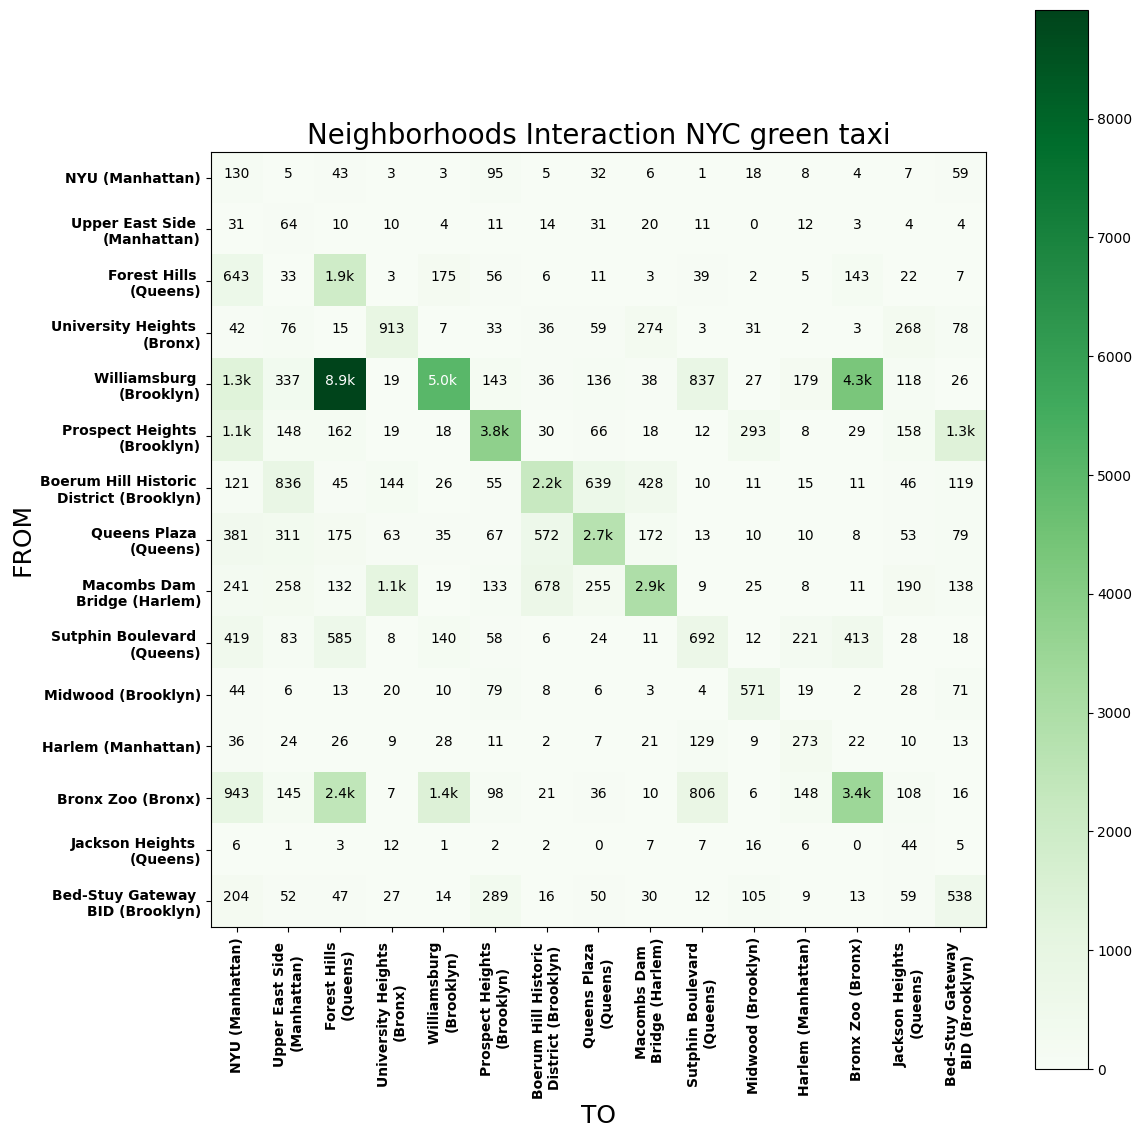

In [201]:
green_cls_label = ['NYU (Manhattan)', 'Upper East Side \n(Manhattan)', 'Forest Hills \n(Queens)','University Heights \n(Bronx)','Williamsburg \n(Brooklyn)', 'Prospect Heights \n(Brooklyn)','Boerum Hill Historic \nDistrict (Brooklyn)','Queens Plaza \n(Queens)','Macombs Dam \nBridge (Harlem)','Sutphin Boulevard \n(Queens)','Midwood (Brooklyn)', 'Harlem (Manhattan)','Bronx Zoo (Bronx)', 'Jackson Heights \n(Queens)','Bed-Stuy Gateway \nBID (Brooklyn)']
#green_cls_label = ['NYU', 'Upper_East', 'Forest Hills','The Bronx \n(University Heights)','McCarren Park \n(Brooklyn)', 'Prospect Park \n(Brooklyn)','Bergen Street \n(Brooklyn)','Queens Plaza','Macombs Dam \nBridge','JFK','Washington Cemetery \n(Brooklyn)', 'Harlem','Bronx Zoo', 'Jackson Heights','Saratoga Park \n(Brooklyn)']
title='Neighborhoods Interaction NYC green taxi'
plot_trip_summary(trip_summary_g_matrix, green_cls_label,title,cmap=plt.cm.Greens)

In [202]:
trip_summary_g_matrix_diag = sum(trip_summary_g_matrix[i][i] for i in np.arange(15))
print('{:.2f}% ({}/{}) green taxi trips run locally'.format(trip_summary_g_matrix_diag/trip_summary_g_matrix.sum()*100, trip_summary_g_matrix_diag, trip_summary_g_matrix.sum()))

38.75% (25183/64995) green taxi trips run locally


In [ ]:
# trip_summary_y = cl_yellow_df.groupby(['pick_cl', 'drop_cl']).count()[['trip_ID']].rename(columns = {'trip_ID': 'number_of_trips'}).unstack(fill_value=0).stack()
# trip_summary_y.reset_index(inplace = True)
# trip_summary_y_matrix = np.reshape(trip_summary_y.number_of_trips.values, (15,15))

In [ ]:
# yellow_cls_label = ['Midtown East \n(53rd Str, Manhattan)','JFK','LGA','Lower East Side \n(Manhattan)','Upper West Side \n(Manhattan)','Columbus Circle \n(Manhattan)','City Hall \n(Manhattan)','Greenpoint \n(Brooklyn)', 'Upper East Side \n(Manhattan)','West Village \n(Manhattan)', 'Park Slope \n(Brooklyn)', 'Queens Plaza \n(Queens)', 'Harlem (Manhattan)', 'Newark', 'Herald Square \n(Manhattan)']
# title='Neighborhoods Interaction NYC yellow taxi'
# plot_trip_summary(trip_summary_y_matrix, yellow_cls_label,title,cmap=plt.cm.Oranges)

In [ ]:
# trip_summary_y_matrix_diag = sum(trip_summary_y_matrix[i][i] for i in np.arange(15))
# print('{:.2f}% ({}/{}) yellow taxi trips run locally'.format(trip_summary_y_matrix_diag/trip_summary_y_matrix.sum()*100, trip_summary_y_matrix_diag, trip_summary_y_matrix.sum()))

Based on the heatmap, I have discovered several interesting patterns:

1.A large percentage of the NYC green and yellow taxis run short trips locally, as revealed by the high intensity in the diagonal of the heatmap. 47.63% of green taxi trips and 23.93% of yellow taxi trips run in the same cluster neighborhood.

2.Heatmap for neighborhood interactions of yellow taxi trips has a symmetrical pattern, suggesting that there is an approximately equal number of trips that operate between two areas in either direction.

3.Harlem has a high green taxi density and there are more outbound trips than inbound trips especially in directions towards Upper East Side and Macombs Dam Bridge (connecting Harlem and Bronx).

4.The Upper East Side, midtown and downtown area of Manhattan all have very high yellow taxi density.

Error Values for Modelling:
1. having negative value: `fare_amount`, `extra`, `mta_tax`, `tip_amount`, `improvement_surcharge`, `total_amount`, `congestion_surcharge`
2. invalid value such 

In [101]:
print(len(clean_green_tripdata[clean_green_tripdata["fare_amount"] < 0]))
print(len(clean_green_tripdata[clean_green_tripdata["extra"] < 0]))
print(len(clean_green_tripdata[clean_green_tripdata["mta_tax"] < 0]))
print(len(clean_green_tripdata[clean_green_tripdata["tip_amount"] < 0]))
print(len(clean_green_tripdata[clean_green_tripdata["improvement_surcharge"] < 0]))
print(len(clean_green_tripdata[clean_green_tripdata["total_amount"] < 0]))
print(len(clean_green_tripdata[clean_green_tripdata["congestion_surcharge"] < 0]))

156
76
151
4
165
165
4


In [113]:
print(len(clean_green_tripdata[(clean_green_tripdata["extra"] == 0.5) | (clean_green_tripdata["extra"] == 1) | (clean_green_tripdata["extra"] == 0)]))

44617
